# ML2 PROJECT 2025 - GEORGIOS KRITOPOULOS 

<p style="text-align:center;">STATE OF THE ART MODEL FOR SENTIMENT ANALYSIS</p>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from datasets import load_dataset
from collections import Counter
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

## 1) Configuration

The model configuration employed in this project is based on DistilBERT, a distilled version of the original BERT (Bidirectional Encoder Representations from Transformers) model,

In [2]:
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2 # Binary classification (positive/ negative)

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

## 2) Loading the dataset

The dataset utilized in this project was sourced from the IMDB collection, which comprises a large volume of movie reviews annotated with sentiment labels.

It was loaded using the Hugging Face datasets library, which provides seamless access to standardized and preprocessed NLP datasets, enabling efficient handling of both training and evaluation data splits.

In [3]:
dataset = load_dataset("imdb")

total = 7000 

# Apply 80/20 split rule
train_size = int(0.8 * total) 
test_size = total - train_size

train_dataset = dataset["train"].shuffle(seed=RANDOM_SEED).select(range(train_size))
test_dataset = dataset["test"].shuffle(seed=RANDOM_SEED).select(range(test_size))

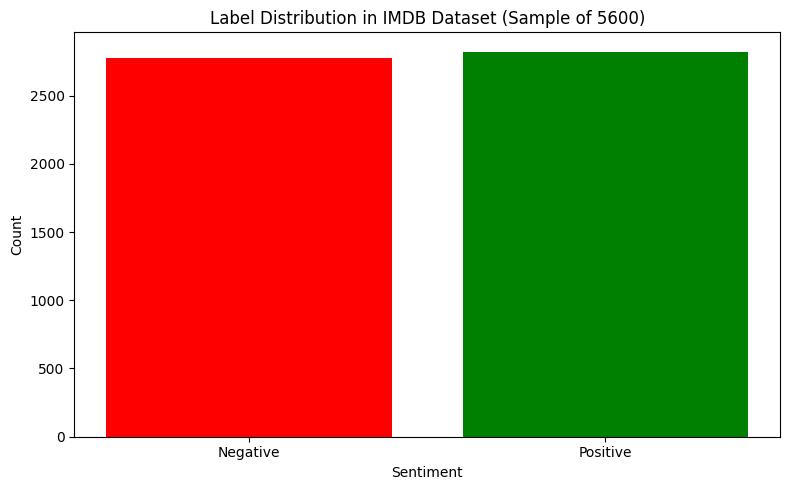

In [4]:
labels = train_dataset["label"]
label_counts = Counter(labels)

counts = [label_counts[0], label_counts[1]]

plt.figure(figsize=(8, 5))
plt.bar(['Negative', 'Positive'], counts, color=['red', 'green'])
plt.title(f'Label Distribution in IMDB Dataset (Sample of {train_size})')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [5]:
print(f"Train samples: {train_size}", f"Test samples: {test_size}")
print(f"Label distribution: {np.bincount(train_dataset['label'])}")

Train samples: 5600 Test samples: 1400
Label distribution: [2778 2822]


## 3) Tokenization

This section outlines the tokenization process, which involves initializing a pre-trained tokenizer and systematically applying it to our dataset.

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

In [7]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=32)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=32)

In [8]:
columns = ["input_ids", "attention_mask", "label"]
train_dataset.set_format(type="torch", columns=columns)
test_dataset.set_format(type="torch", columns=columns)

## 4) Training Arguments

In this section, we define the training arguments that govern the fine-tuning process of the model.

In [9]:
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    num_train_epochs=4,
    per_device_train_batch_size=8,  # Batch size for training on each device (e.g., GPU)
    per_device_eval_batch_size=16,  # Batch size for evaluation on each device (e.g., GPU)
    gradient_accumulation_steps=2,  # Number of steps to accumulate gradients before updating the model
    learning_rate=5e-6,  # Learning rate for the optimizer during training
    weight_decay=0.01,  # Weight decay (L2 regularization) applied during training
    warmup_steps=100,  # Number of warmup steps to gradually increase the learning rate
    logging_steps=10,  # Log training information every 10 steps
    eval_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch
    seed=RANDOM_SEED,  # Random seed for reproducibility
    load_best_model_at_end=True,  # Load the best model based on evaluation at the end of training
    metric_for_best_model="f1",  # Metric used to determine the best model (We chose F1 score)
    report_to="none",  # Disable reporting to external platforms like TensorBoard, WandB, etc.
    fp16=False  # Disable mixed-precision training (mainly intended for NVIDIA GPUs that support CUDA and mixed-precision training via AMP)
)

To enhance the model's generalization capability and mitigate the risk of overfitting, a dropout layer should be incorporated into the architecture. This technique randomly deactivates a fraction of neurons during training, thereby promoting robustness by preventing the model from becoming overly reliant on specific features.

In [10]:
class RegularizedModel(AutoModelForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(p=0.3)  # Dropout rate

    def forward(self, *args, **kwargs):
        outputs = super().forward(*args, **kwargs)
        outputs.logits = self.dropout(outputs.logits)
        return outputs

In [11]:
model = RegularizedModel.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    return {"accuracy": accuracy_score(labels, preds), "precision": precision, "recall": recall, "f1": f1}

We incorporated a utility function to monitor and report the memory consumption of the system both before and after the training phase. This allows for better resource management and helps identify potential memory bottlenecks during model development, especially when working with large transformer architectures.

In [13]:
def print_memory_usage():
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**2:.2f}MB")
    else:
        import psutil
        print(f"RAM Usage: {psutil.Process().memory_info().rss/1024**2:.2f}MB")

In [14]:
print("Memory before training:")
print_memory_usage()

Memory before training:
RAM Usage: 982.05MB


## 5) Model Training

This section initializes the trainer and starts the training process.

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [16]:
print("\nStarting training...")

trainer.train()

print("\nTraining completed!")


Starting training...


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.325400,0.305780,0.872857,0.881737,0.856105,0.868732
2,0.252000,0.282333,0.880000,0.859116,0.904070,0.881020
3,0.338600,0.287322,0.883571,0.858117,0.914244,0.885292
4,0.161100,0.289635,0.887143,0.868056,0.908430,0.887784


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed!


In [17]:
print("Memory after training:")
print_memory_usage()

Memory after training:
RAM Usage: 1361.25MB


## 6) Saving the Model

This section saves the fine-tuned model and tokenizer for future use.

In [18]:
trainer.save_model("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json',
 './fine_tuned_bert/tokenizer.json')

We will view the model architecture,

In [19]:
model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_bert')
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 7) Evaluating the Model

In [20]:
training_logs = trainer.state.log_history
epochs = [log['epoch'] for log in training_logs if 'epoch' in log]
train_loss = [log['loss'] for log in training_logs if 'loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

To maintain consistent training metrics, we will ensure the lists for epochs and training loss are of equal length, and that evaluation accuracy aligns with the number of epochs for accurate plotting and tracking.

In [21]:
min_length = min(len(epochs), len(train_loss))
epochs = epochs[:min_length]
train_loss = train_loss[:min_length]

In [22]:
if len(eval_accuracy) < len(epochs):
    eval_accuracy.extend([None] * (len(epochs) - len(eval_accuracy)))

To ensure accurate plotting, it is important to filter out any None values

In [23]:
valid_indices = [i for i, acc in enumerate(eval_accuracy) if acc is not None]
filtered_epochs = [epochs[i] for i in valid_indices]
filtered_eval_accuracy = [eval_accuracy[i] for i in valid_indices]

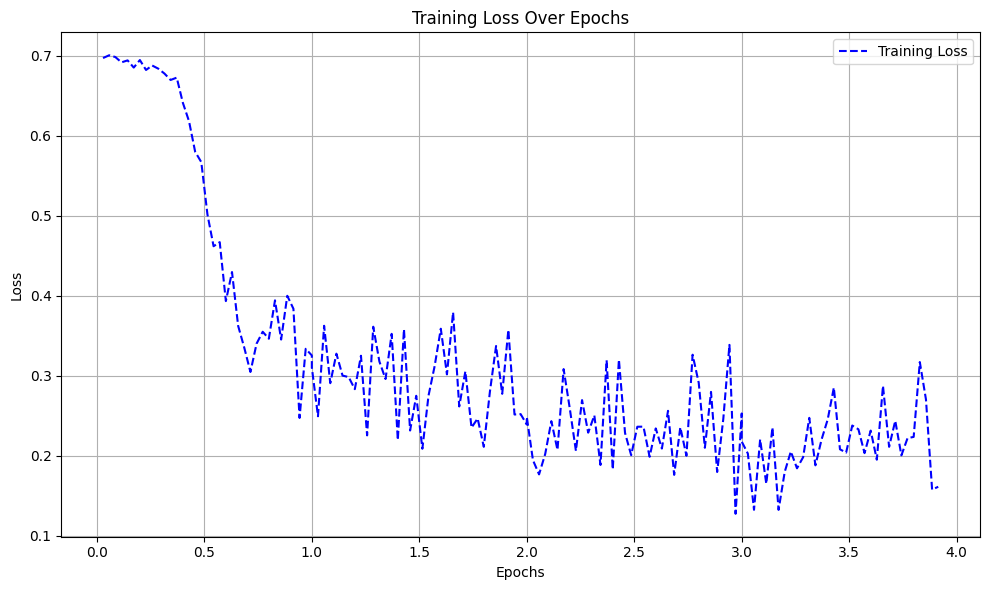

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [25]:
eval_accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]
eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
eval_precision = [log['eval_precision'] for log in training_logs if 'eval_precision' in log]
eval_recall = [log['eval_recall'] for log in training_logs if 'eval_recall' in log]
eval_f1 = [log['eval_f1'] for log in training_logs if 'eval_f1' in log]

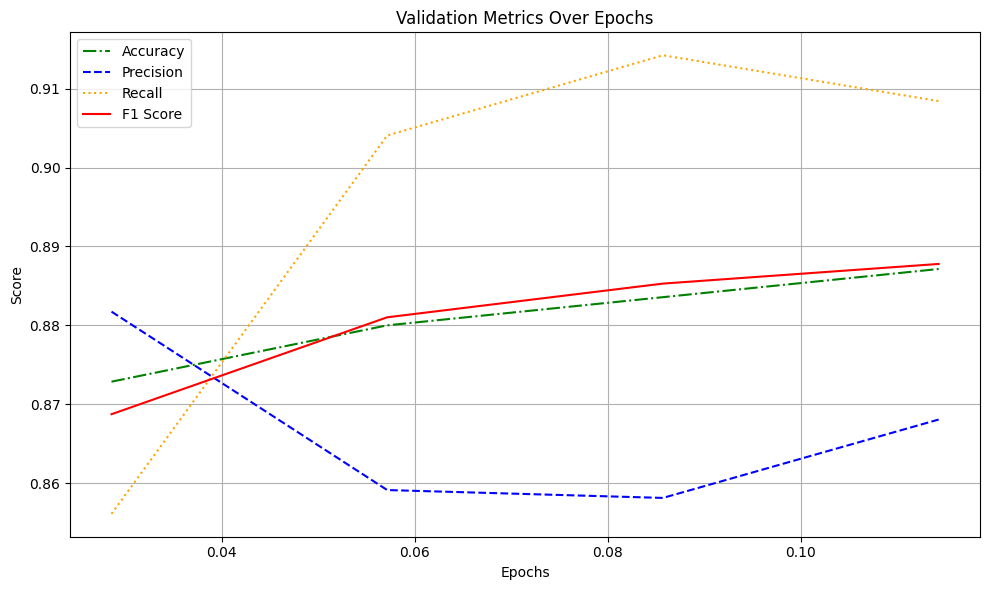

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_epochs, eval_accuracy, label='Accuracy', color='green', linestyle='-.')
plt.plot(filtered_epochs, eval_precision, label='Precision', color='blue', linestyle='--')
plt.plot(filtered_epochs, eval_recall, label='Recall', color='orange', linestyle=':')
plt.plot(filtered_epochs, eval_f1, label='F1 Score', color='red', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

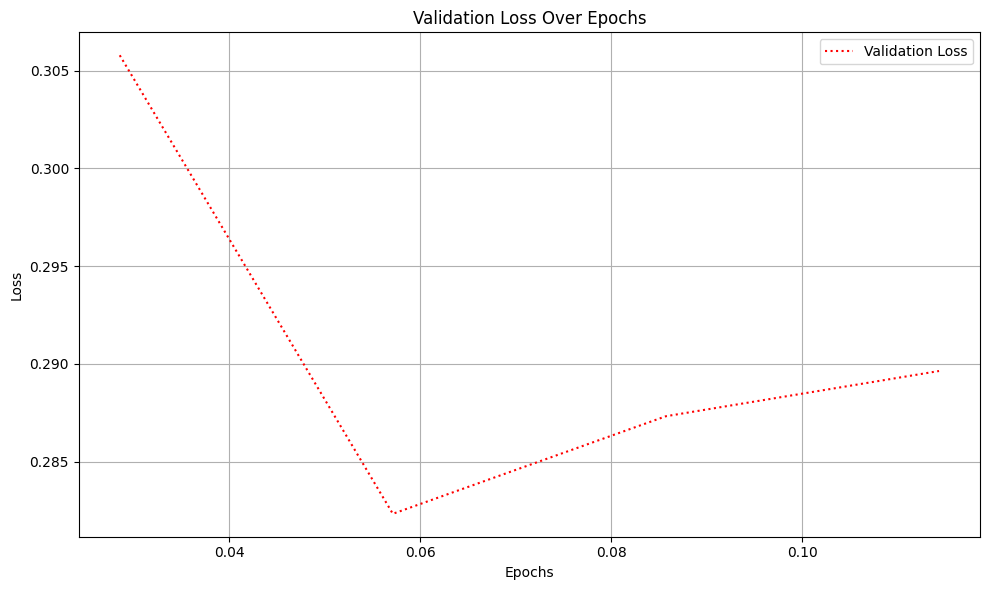

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_epochs, eval_loss, label='Validation Loss', color='red', linestyle=':')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Confusion Matrix:


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


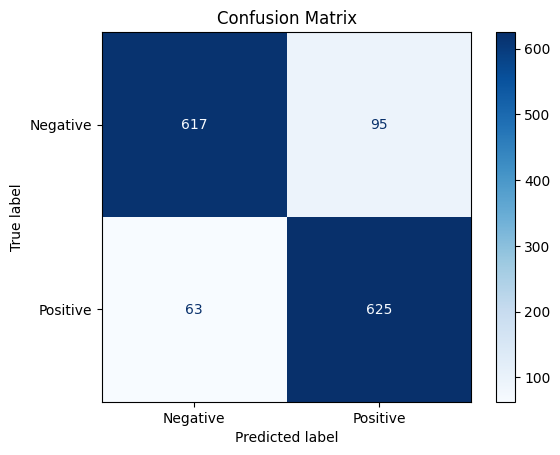

In [28]:
def plot_confusion_matrix(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

print("Confusion Matrix:")
plot_confusion_matrix(trainer, test_dataset)

ROC Curve:


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


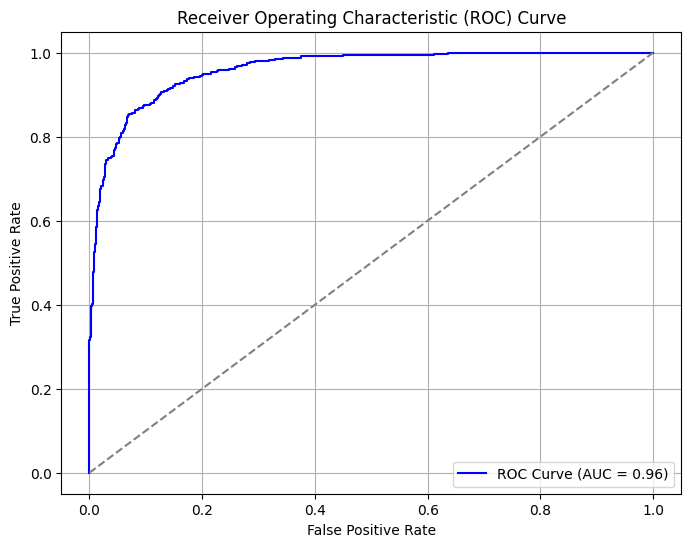

In [29]:
def plot_roc_curve(trainer, dataset):
    predictions = trainer.predict(dataset)
    probs = predictions.predictions[:, 1]
    labels = predictions.label_ids
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))

    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

print("ROC Curve:")
plot_roc_curve(trainer, test_dataset)

## Sentiment Analysis Web App

Run the Streamlit app (`streamlit_bert.py`) directly from the Jupyter Notebook.

In [33]:
#!pip install streamlit

In [34]:
!streamlit run streamlit_bert.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.5.0.2:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
^C
